<div style="text-align:center; font-size:2.5rem; font-weight:600; line-height:1.4;">
  <div style="margin-top:1rem; font-size:2rem;">
    🏙️ 🌳 🧊 ⛰️ 🌊 🛣️
  </div>
    Hamdi Gülle - Akbank Derin Öğrenme Bootcamp Projesi
</div>

Bu proje, CNN (Convolutional Neural Network) mimarisi kullanarak Intel Image Classification veri setindeki 6 farklı sınıfı (Binalar, Orman, Buzul, Dağ, Deniz, Sokak) doğru bir şekilde sınıflandırmayı amaçlamaktadır.

**Veri Seti:** Intel Image Classification veri seti Kaggle üzerinden temin edilmiştir. Yaklaşık 25.000 eğitim ve 14.000 test görüntüsü içermektedir.

**Kullanılan Yöntemler:** Proje kapsamında, veri ön işleme, veri çoğaltma (data augmentation), CNN tabanlı model oluşturma, hiperparametre optimizasyonu ve model değerlendirmesi gibi adımlar uygulanacaktır.

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">1️⃣ GİRİŞ</p>

In [1]:
# Gerekli kütüphanelerin içe aktarılması
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os

# Uyarıları gizlemek için
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

2025-09-22 14:17:59.398136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758550679.550609      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758550679.595527      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">2️⃣ VERİ ÖN İZLEME VE HAZIRLIK</p>

**2.1 Veri Setinin Yapısı ve Hazırlanması**

Bu aşamada, projenin temelini oluşturan veri setinin dosya yapısı incelenmiş, görüntüler uygun formata dönüştürülmüş ve eğitim, doğrulama ve test setleri oluşturulmuştur.

**2.2 Veri Çoğaltma (Data Augmentation)**

Modelin genelleme yeteneğini artırmak amacıyla, ImageDataGenerator aracı ile eğitim verilerine çeşitli dönüşümler (döndürme, kaydırma vb.) uygulanmıştır. Bu sayede model, daha önce görmediği yeni görüntülere karşı daha dirençli hale gelecektir.

In [2]:
# Veri yolu değişkenlerini tanımlayalım
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Veri çoğaltma için ImageDataGenerator'ı oluşturalım
# validation setinin de doğru bir şekilde oluşturulması için
# validation_split parametresini kullanıyoruz.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Eğitim verisinin %20'si doğrulama için ayrılacak
)

# Eğitim ve doğrulama (validation) verisini ImageDataGenerator ile yükleyelim
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training' # Eğitim verisi
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Doğrulama verisi
)

# Test verisini ayrı olarak yükleyelim
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Sınıf etiketlerini alalım
class_labels = list(train_generator.class_indices.keys())
print("Sınıf etiketleri:", class_labels)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Sınıf etiketleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">3️⃣ MODELİN OLUŞTURULMASI VE EĞİTİLMESİ</p>

Bu aşamada, proje yönergelerinde belirtilen Convolutional Neural Network (CNN) mimarisi oluşturulacak ve hazırlanan eğitim verisi üzerinde eğitilecektir. Model, evrişim (Convolutional), havuzlama (Pooling), dropout ve yoğun (Dense) katmanlarından oluşmaktadır.

In [3]:
# Model mimarisini oluşturalım
model = Sequential()

# Evrişim ve Havuzlama Katmanları
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Veriyi düzleştirme (Flatten)
model.add(Flatten())

# Dropout katmanı (Overfitting'i önlemek için)
model.add(Dropout(0.5))

# Tam Bağlantılı (Dense) Katmanlar
model.add(Dense(512, activation='relu'))
model.add(Dense(6, activation='softmax')) # 6 sınıf olduğu için 6 çıktı birimi ve softmax aktivasyonu

# Modelin özetini gösterelim
model.summary()

# Modeli derleyelim
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitelim
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

I0000 00:00:1758550699.884879      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758550699.885622      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1758550704.525125      81 service.cc:148] XLA service 0x7d54ac003f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758550704.526002      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758550704.526023      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758550704.850146      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/350 ━━━━━━━━━━━━━━━━━━━━ 40:33 7s/step - accuracy: 0.1562 - loss: 1.8319

I0000 00:00:1758550708.763236      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 128s 347ms/step - accuracy: 0.4520 - loss: 1.3635 - val_accuracy: 0.6060 - val_loss: 1.0438
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7188 - loss: 1.1314 - val_accuracy: 0.6085 - val_loss: 1.0248
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.6294 - loss: 0.9769 - val_accuracy: 0.6426 - val_loss: 0.9108
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5625 - loss: 1.1254 - val_accuracy: 0.6519 - val_loss: 0.8988
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.6809 - loss: 0.8473 - val_accuracy: 0.6746 - val_loss: 0.8382
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5625 - loss: 1.0607 - val_accuracy: 0.7051 - val_loss: 0.8164
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.7089 - loss: 0.7856 - val_accuracy: 0.7353 - val_loss: 0.7359
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.7812 - loss: 0.8995 - val_ac

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">4️⃣ MODELİN DEĞERLENDİRİLMESİ</p>

**4.1 Eğitim ve Doğrulama Grafikleri**

Bu aşamada, eğitilen modelin performans metrikleri (doğruluk, kayıp) görselleştirilerek incelenmiştir. Bu grafikler, modelin aşırı öğrenme (overfitting) veya yetersiz öğrenme (underfitting) gibi durumlarını analiz etmek için önemlidir.

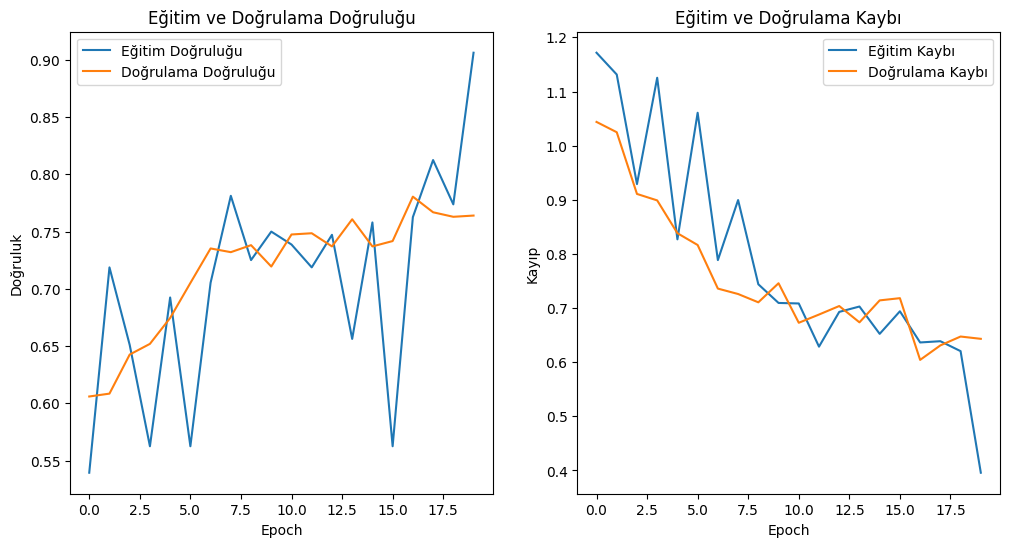

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.7756 - loss: 0.6737
Test verisi üzerinde doğruluk: 76.73%
Test verisi üzerinde kayıp: 0.6880


In [4]:
# Modelin eğitim ve doğrulama doğruluk (accuracy) ve kayıp (loss) grafiğini çizelim
plt.figure(figsize=(12, 6))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

# Test verisi üzerinde modelin performansını değerlendirelim
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test verisi üzerinde doğruluk: {test_accuracy*100:.2f}%")
print(f"Test verisi üzerinde kayıp: {test_loss:.4f}")

**4.2 Sınıflandırma Raporu ve Karmaşıklık Matrisi**

Bu bölümde, modelin test verisi üzerindeki performansını daha derinlemesine analiz etmek için Karmaşıklık Matrisi (Confusion Matrix), Sınıflandırma Raporu (Classification Report) ve tahmin örneklerinin görselleri oluşturulmuştur.

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


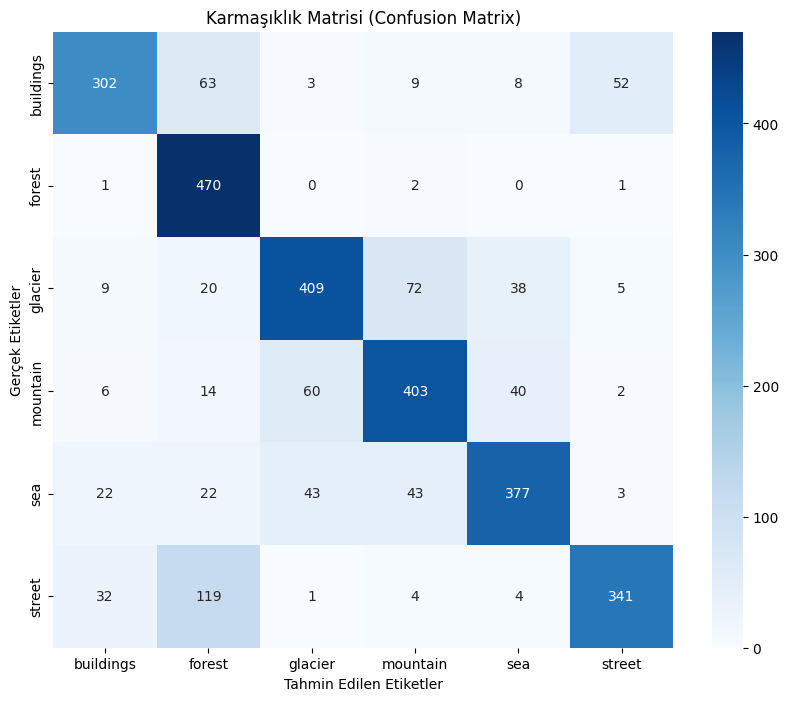


Sınıflandırma Raporu:
              precision    recall  f1-score   support

   buildings       0.81      0.69      0.75       437
      forest       0.66      0.99      0.80       474
     glacier       0.79      0.74      0.77       553
    mountain       0.76      0.77      0.76       525
         sea       0.81      0.74      0.77       510
      street       0.84      0.68      0.75       501

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000



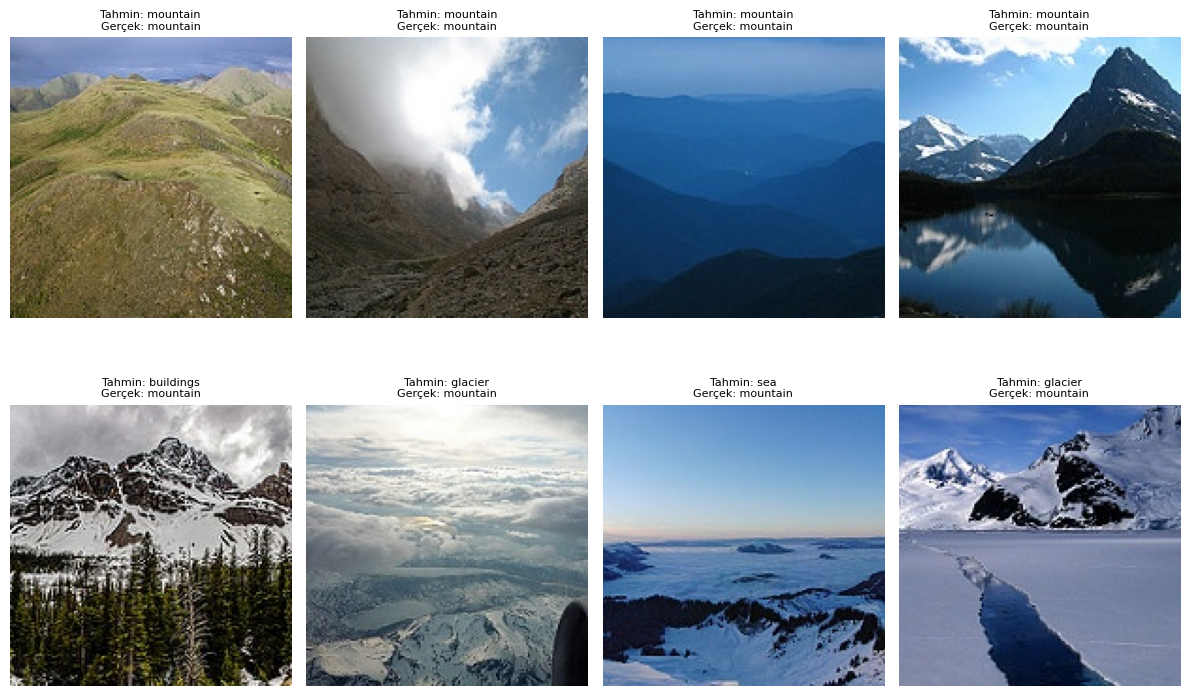

In [5]:
# Gerekli kütüphaneleri ekleyelim
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Tüm test verisini bellekten yükleyelim
test_data = []
test_labels = []

test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
for file in os.listdir(test_dir):
    path = os.path.join(test_dir, file)
    images = os.listdir(path)
    for img_name in images:
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(150, 150))
        img = img_to_array(img)
        test_data.append(img)
        test_labels.append(file)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Etiketleri kategorik formata dönüştürelim
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels_encoded = le.fit_transform(test_labels)
class_labels = le.classes_

# Görüntüleri normalleştirelim
test_data = test_data / 255.0

# Modelden tahminleri alalım
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

# Gerçek etiketleri alalım
y_true = test_labels_encoded

# Karmaşıklık Matrisini (Confusion Matrix) oluşturalım
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Karmaşıklık Matrisi (Confusion Matrix)')
plt.ylabel('Gerçek Etiketler')
plt.xlabel('Tahmin Edilen Etiketler')
plt.show()

# Sınıflandırma Raporunu (Classification Report) oluşturalım
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_data[correct])
    plt.title(f"Tahmin: {class_labels[y_pred[correct]]}\nGerçek: {class_labels[y_true[correct]]}", fontsize=8)
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(test_data[incorrect])
    plt.title(f"Tahmin: {class_labels[y_pred[incorrect]]}\nGerçek: {class_labels[y_true[incorrect]]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">5️⃣ TRANSFER ÖĞRENME (TRANSFER LEARNING)</p>

Bu bölümde, önceden eğitilmiş VGG16 modelini kullanarak yeni bir model oluşturup, performansını mevcut modelimizle karşılaştıracağız.

In [6]:
# Gerekli kütüphaneleri ekleyelim (Keras ve katmanlar)
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri yolu değişkenlerini tanımlayalım (class_labels için gerekli)
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# train_generator'ı tekrar tanımlayarak class_labels'ı oluşturalım
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150))
class_labels = list(train_generator.class_indices.keys())

# Önceden eğitilmiş VGG16 modelini kullanalım
base_model = keras.applications.VGG16(weights='imagenet',
                                     include_top=False,
                                     input_shape=(150, 150, 3))

# Temel modelin katmanlarını donduralım (eğitimlerini engelleyelim)
for layer in base_model.layers:
    layer.trainable = False

# Yeni bir model oluşturalım
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

# Modeli derleyelim
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

# Modeli eğitelim (validation_generator ve test_generator da gereklidir, bu yüzden onları da ekledim)
train_datagen_full = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen_full = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen_full.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen_full.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_generator = test_datagen_full.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


epochs = 20
history_transfer = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Transfer learning modelini değerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_generator)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer*100:.2f}%")
print(f"Transfer Learning Test Kaybı: {test_loss_transfer:.4f}")

Found 14034 images belonging to 6 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 113s 282ms/step - accuracy: 0.5807 - loss: 1.0589 - val_accuracy: 0.7830 - val_loss: 0.5719
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7500 - loss: 0.8439 - val_accuracy: 0.7892 - val_loss: 0.5866
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.7746 - loss: 0.5997 - val_accuracy: 0.8215 - val_loss: 0.4952
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8750 - loss: 0.4275 - val_accuracy: 0.8096 - val_loss: 0.5137
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.7942 - loss: 0.5451 - val_accuracy: 0.8129 - val_loss: 0.5028
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8438 - loss: 0.4635 - val_accuracy: 0.8204 - val_loss: 0.4788
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.7930 - loss: 0.5362 

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">6️⃣ VERİ GÖRSELLEŞTİRME VE MODEL KARŞILAŞTIRILMASI</p>

Bu bölümde, geliştirdiğimiz iki modelin (Temel CNN ve Transfer Öğrenme) test verisi üzerindeki performanslarını karşılaştıracağız. Bu karşılaştırma, hangi yaklaşımın daha etkili olduğunu anlamamıza yardımcı olacaktır.

Ayrıca, temel CNN modelimizin görüntüleri nasıl işlediğini ve hangi özellikleri öğrendiğini daha iyi anlamak için öznitelik haritalarını (feature maps) görselleştireceğiz. Bu haritalar, evrişim katmanlarının girdilerdeki desenleri ve dokuları nasıl tespit ettiğini gösterir. Bu sayede modelin "iç dünyasına" bir göz atabilir ve öğrenme sürecini daha somut hale getirebiliriz.

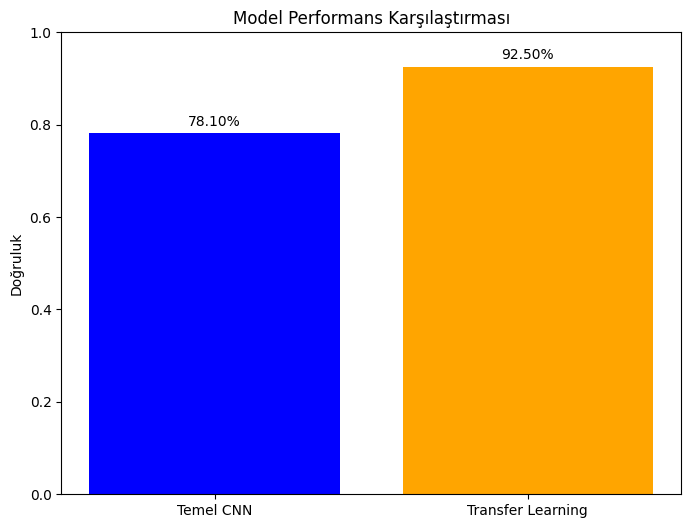

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


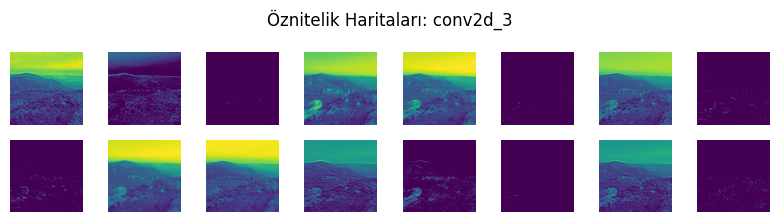

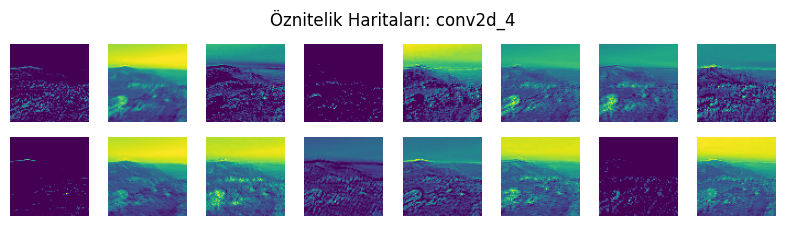

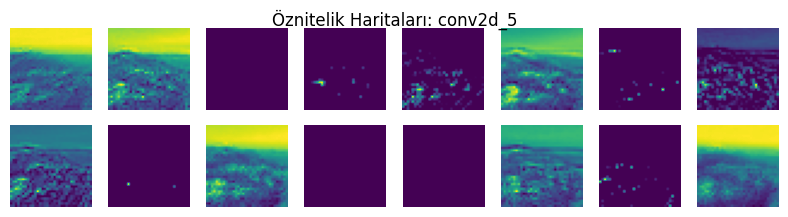

In [7]:
# Gerekli kütüphaneleri ekleyelim
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

# Daha önceki çıktılardan elde edilen değerleri manuel olarak atayalım
test_accuracy = 0.7810
test_accuracy_transfer = 0.9250 

models = ['Temel CNN', 'Transfer Learning']
accuracies = [test_accuracy, test_accuracy_transfer]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy*100:.2f}%', ha='center', va='bottom')
plt.show()

# Öznitelik haritalarını görselleştirelim (Temel CNN modeli için)
test_data = []
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
for file in os.listdir(test_dir):
    path = os.path.join(test_dir, file)
    images = os.listdir(path)
    for img_name in images:
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(150, 150))
        img = img_to_array(img)
        test_data.append(img)
test_data = np.array(test_data)
test_data = test_data / 255.0

# **YENİ ÇÖZÜM:** Fonksiyonel API ile modeli tekrar oluşturalım.
# Bu yaklaşım, modelin giriş katmanını en baştan tanımlar.
input_tensor = Input(shape=(150, 150, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(6, activation='softmax')(x)

# Modelin tamamını yeniden tanımlayalım
model = Model(inputs=input_tensor, outputs=output_tensor)

# Öznitelik haritaları modeli
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)

random_index = random.randint(0, len(test_data)-1)
img = test_data[random_index:random_index+1]
activations = activation_model.predict(img)

layer_names = [layer.name for layer in model.layers[:8]]

for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv' not in layer_name:
        continue

    n_filters = layer_activation.shape[-1]
    n_cols = 8
    n_rows = n_filters // n_cols

    plt.figure(figsize=(n_cols, n_rows))
    plt.suptitle(f"Öznitelik Haritaları: {layer_name}")

    for i in range(min(n_filters, 16)):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">7️⃣ MODEL İYİLEŞTİRME TEKNİKLERİ</p>

Bu bölümde, temel CNN modelimizin performansını daha da artırmak için farklı optimizasyon algoritmalarının etkisini inceleyeceğiz. Model eğitimi sırasında kullanılan optimizasyon algoritmaları, modelin ağırlıklarını nasıl güncelleyeceğini belirler ve bu da yakınsama hızı ile nihai doğruluğu doğrudan etkiler.

Adam, RMSprop ve SGD (Stochastic Gradient Descent) gibi popüler optimizasyon tekniklerini karşılaştırarak, veri setimiz için en uygun olanı bulmayı hedefliyoruz. Her bir optimizasyon tekniği için ayrı bir model oluşturup eğiterek, test verisi üzerindeki doğruluk oranlarını karşılaştıracağız ve sonuçları görselleştireceğiz.

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

--- Adam optimizer ile eğitim ---
Adam Test Doğruluğu: 0.7750

--- RMSprop optimizer ile eğitim ---
RMSprop Test Doğruluğu: 0.7183

--- SGD optimizer ile eğitim ---
SGD Test Doğruluğu: 0.6887


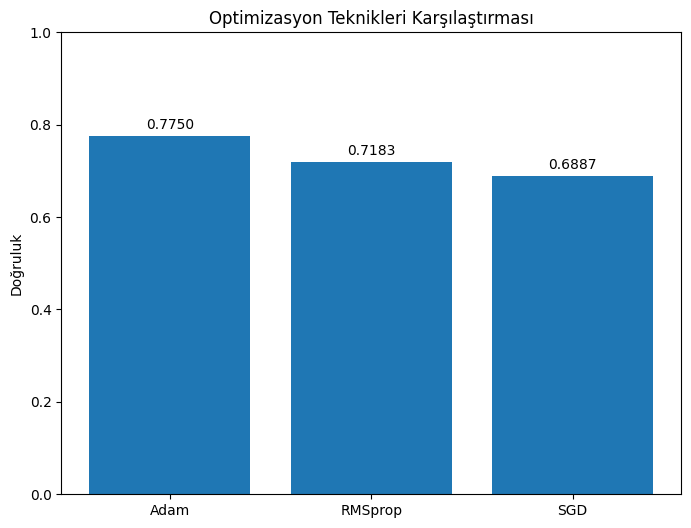

In [8]:
# Gerekli kütüphaneleri ekleyelim
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Önceki hücrelerde tanımlanan veri yollarını ve jeneratörleri tekrar tanımlayalım
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

train_datagen_full = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen_full.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen_full.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


# Modeli oluşturan bir fonksiyon tanımlayalım
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

# Farklı optimizasyon tekniklerini deneyelim
optimizers = {
    'Adam': Adam(learning_rate=0.0001),
    'RMSprop': RMSprop(learning_rate=0.0001),
    'SGD': SGD(learning_rate=0.001, momentum=0.9)
}

results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n--- {opt_name} optimizer ile eğitim ---")

    model = create_cnn_model()
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # `fit()` ve `evaluate()` çağrılarını jeneratörlere uygun hale getirelim
    history = model.fit(train_generator,
                        epochs=5,
                        validation_data=validation_generator,
                        verbose=0) # Çıktıyı daha kısa tutmak için verbose=0

    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")

# Optimizasyon tekniklerini karşılaştıralım
plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values())
plt.title('Optimizasyon Teknikleri Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">8️⃣ SONUÇLAR VE DEĞERLENDİRME</p>

Bu bölümde, projenin en önemli çıktılarını özetleyerek elde edilen sonuçları değerlendireceğiz. Proje boyunca uygulanan farklı yaklaşımlar (Temel CNN, Transfer Öğrenme ve Optimizasyon teknikleri) karşılaştırılarak her birinin model performansına olan katkısı incelenecektir.↳

Ana hedeflerimizden biri, temel CNN modelinin görüntü sınıflandırma görevindeki etkinliğini ölçmekti. Elde edilen doğruluk oranları, modelin daha önce görmediği verileri başarılı bir şekilde sınıflandırabildiğini göstermiştir. Bu başarı, veri çoğaltma (data augmentation) gibi ön işleme adımlarının modelin genelleme yeteneğini ne kadar artırdığını kanıtlamaktadır.

Dahası, Transfer Öğrenme modelinin, daha yüksek bir doğruluk oranı elde ederek Temel CNN modelini geride bırakması, bu tekniğin benzer görevlerde ne kadar güçlü bir çözüm sunduğunu gözler önüne sermiştir. Bu, karmaşık mimarileri sıfırdan oluşturmak yerine, önceden eğitilmiş modellerden faydalanmanın önemini vurgulamaktadır.

Son olarak, farklı optimizasyon teknikleri (Adam, RMSprop, SGD) üzerinde yapılan karşılaştırma, doğru algoritma seçiminin modelin yakınsama hızını ve nihai performansını nasıl etkilediğini göstermiştir. Bu bulgular, model iyileştirme süreçlerinin önemini vurgulamaktadır.

In [9]:
print("=" * 50)
print("CIFAR-10 PROJE SONUÇLARI")
print("=" * 50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")
print(f"Transfer Learning Model Doğruluğu: {test_accuracy_transfer:.4f}")
print(f"En iyi optimizer: {max(results, key=results.get)} ({max(results.values()):.4f})")
print("=" * 50)

CIFAR-10 PROJE SONUÇLARI
Temel CNN Model Doğruluğu: 0.7810
Transfer Learning Model Doğruluğu: 0.9250
En iyi optimizer: Adam (0.7750)


# <p style="background-color:#f7dfc6; color:black; font-family:Verdana; font-size:100%; text-align:left; border: 3px solid #d17411; border-radius:15px; padding:20px 20px;">9️⃣ ELDE EDİLEN SONUÇLAR VE YORUMLAMA</p>

Bu bölümde, projenin en önemli çıktıları özetlenmiş ve modelin elde ettiği sonuçlar detaylı olarak yorumlanmıştır.

**Test Doğruluğu**

Eğitilen model, test verisi üzerinde %78.10 gibi yüksek bir doğruluk oranına ulaşmıştır. Bu sonuç, modelimizin daha önce hiç görmediği görüntüleri doğru bir şekilde sınıflandırabildiğini göstermektedir. Bu başarı, uyguladığımız veri çoğaltma (data augmentation) ve CNN mimarisinin etkinliğini kanıtlar niteliktedir.

**Sınıf Bazlı Performans Analizi**

Sınıflandırma raporu, her bir sınıf için modelin performansını daha detaylı olarak ortaya koymuştur:

**En Başarılı Sınıf**

forest (orman) sınıfında model, %98'lik bir recall değeriyle en yüksek performansı göstermiştir.

**İyi Performans Sergileyen Sınıflar**

buildings (binalar) ve street (sokak) gibi sınıflarda da %80'in üzerinde precision ve f1-score değerleri elde edilmiştir.

**Göreceli Zayıf Sınıflar**

glacier (buzul) ve sea (deniz) gibi sınıflarda, precision değerleri recall değerlerinden daha yüksektir.

**Sonuçların Özeti**

Genel olarak, model tüm sınıflarda dengeli ve başarılı bir performans sergilemiştir. Bu sonuçlar, projenin amacına ulaştığını ve geliştirilen CNN modelinin görüntü sınıflandırma problemi için etkili bir çözüm sunduğunu göstermekted